In [ ]:
import geopandas as gpd

# Load the GeoPackage
gdf = gpd.read_file("/content/drive/MyDrive/training_fire/CLARANS/CLARANS_clustered.shp")

# Print the columns
print(gdf.columns)


Index(['ALUM_SAT', 'CLAY', 'ELEC_COND', 'GRIDCODE', 'ORG_CARBON', 'PH_WATER',
       'SAND', 'SILT', 'TEB', 'TOTAL_N', 'aspect1', 'elevation1', 'ndvi1',
       'precip_s1_log10', 'precip_s2_log10', 'precip_s3_log10',
       'precip_s4_log10', 'tmax_s1', 'tmax_s2', 'tmin_s1', 'tmin_s2', 'fire',
       'geometry'],
      dtype='object')


In [ ]:
!pip install pyclustering


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 43.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395100 sha256=8b631a0256af8c8f4a29ecded0826b20baa11eacd327d660fd721c205b24100d
  Stored in directory: /root/.cache/pip/wheels/68/29/b4/131bd7deec3663cc311ab9aa64d6517c3e3ec24bcadfc32f74
Successfully built pyclustering


#grid search

In [ ]:
from sklearn.metrics import silhouette_score
import geopandas as gpd
import numpy as np
from pyclustering.cluster.clarans import clarans
from pyclustering.utils import calculate_distance_matrix



# ------------------------------
# Prepare data for clustering
# ------------------------------
# Drop 'fire' and geometry, reset index to avoid KeyError
X = gdf.drop(columns=['fire', gdf.geometry.name]).reset_index(drop=True)
X_np = X.to_numpy()
best_score = -1
best_params = None
best_labels = None

for num_clusters in [ 3, 4, 5]:
    for numlocal in [1, 2, 3]:
        for maxneighbor in range(1, 6):  # maxneighbor <= 5
            clarans_instance = clarans(X_np, num_clusters, numlocal, maxneighbor)
            clarans_instance.process()
            clusters = clarans_instance.get_clusters()

            # Convert clusters to labels
            labels = np.zeros(X_np.shape[0], dtype=int)
            for cluster_id, cluster_points in enumerate(clusters):
                for idx in cluster_points:
                    labels[idx] = cluster_id

            # silhouette requires at least 2 clusters
            if len(clusters) > 1:
                score = silhouette_score(X_np, labels)
            else:
                score = -1

            if score > best_score:
                best_score = score
                best_params = (num_clusters, numlocal, maxneighbor)
                best_labels = labels

            print(f"num_clusters={num_clusters}, numlocal={numlocal}, maxneighbor={maxneighbor}, silhouette={score:.4f}")

# Assign best clusters to GeoDataFrame
gdf['cluster'] = best_labels
print("\nBest parameters:", best_params, "Silhouette Score:", best_score)
print(gdf['cluster'].value_counts())


num_clusters=3, numlocal=1, maxneighbor=1, silhouette=0.6470
num_clusters=3, numlocal=1, maxneighbor=2, silhouette=0.8934
num_clusters=3, numlocal=1, maxneighbor=3, silhouette=0.6199
num_clusters=3, numlocal=1, maxneighbor=4, silhouette=0.7232
num_clusters=3, numlocal=1, maxneighbor=5, silhouette=0.6317
num_clusters=3, numlocal=2, maxneighbor=1, silhouette=0.8934
num_clusters=3, numlocal=2, maxneighbor=2, silhouette=0.8934
num_clusters=3, numlocal=2, maxneighbor=3, silhouette=0.8934
num_clusters=3, numlocal=2, maxneighbor=4, silhouette=0.2343
num_clusters=3, numlocal=2, maxneighbor=5, silhouette=0.8934
num_clusters=3, numlocal=3, maxneighbor=1, silhouette=0.8934
num_clusters=3, numlocal=3, maxneighbor=2, silhouette=0.7581
num_clusters=3, numlocal=3, maxneighbor=3, silhouette=0.8934
num_clusters=3, numlocal=3, maxneighbor=4, silhouette=0.8934
num_clusters=3, numlocal=3, maxneighbor=5, silhouette=0.8934
num_clusters=4, numlocal=1, maxneighbor=1, silhouette=0.1681
num_clusters=4, numlocal

#Pyclustering

In [ ]:
import geopandas as gpd
import numpy as np
from pyclustering.cluster.clarans import clarans
from sklearn.metrics import silhouette_score

# ------------------------------
# Prepare data for clustering
# ------------------------------
X = gdf.drop(columns=['fire', gdf.geometry.name]).reset_index(drop=True)
X_np = X.to_numpy()

# ------------------------------
# Parameters
# ------------------------------
num_clusters = 3
numlocal = 1
maxneighbor = 2
num_runs = 10  # number of CLARANS runs

best_labels = None
best_score = -1  # silhouette score ranges from -1 to 1

# ------------------------------
# Run CLARANS multiple times
# ------------------------------
for run in range(num_runs):
    clarans_instance = clarans(X_np, num_clusters, numlocal, maxneighbor)
    clarans_instance.process()
    clusters = clarans_instance.get_clusters()

    # Convert clusters to labels
    labels = np.zeros(X_np.shape[0], dtype=int)
    for cluster_id, cluster_points in enumerate(clusters):
        for idx in cluster_points:
            labels[idx] = cluster_id

    # Evaluate using silhouette score
    try:
        score = silhouette_score(X_np, labels)
    except:
        score = -1  # in case silhouette fails for tiny clusters

    # Keep the best run
    if score > best_score:
        best_score = score
        best_labels = labels

# ------------------------------
# Assign best labels to GeoDataFrame
# ------------------------------
gdf['cluster'] = best_labels

print(f"Best silhouette score: {best_score:.4f}")


Best silhouette score: 0.8934


In [ ]:
output_path = "/content/drive/MyDrive/training_fire/CLARANS/CLARANS_clustered.shp"
gdf.to_file(output_path)
print(f"GeoDataFrame with clusters saved to: {output_path}")

/tmp/ipython-input-771590930.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_path)


GeoDataFrame with clusters saved to: /content/drive/MyDrive/training_fire/CLARANS/CLARANS_clustered.shp


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'precip_s1_log10' to 'precip_s1_'
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'precip_s2_log10' to 'precip_s2_'
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'precip_s3_log10' to 'precip_s3_'
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'precip_s4_log10' to 'precip_s4_'
  ogr_write(


In [ ]:
!pip install permetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.9 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


mask = gdf['cluster'] != -1
X_filtered = X[mask]
labels_filtered = gdf['cluster'][mask]

# Silhouette Score
sil_score = silhouette_score(X_filtered, labels_filtered)
print("Silhouette Score:", sil_score)

# Davies-Bouldin Index (lower is better)
db_score = davies_bouldin_score(X_filtered, labels_filtered)
print("Davies-Bouldin Index:", db_score)

# Calinski-Harabasz Index (higher is better)
ch_score = calinski_harabasz_score(X_filtered, labels_filtered)
print("Calinski-Harabasz Index:", ch_score)


import numpy as np
from permetrics import ClusteringMetric

X_filtered = X_filtered.to_numpy()  # Convert GeoDataFrame to NumPy
labels_filtered = gdf['cluster'][mask].to_numpy()  #  cluster labels

# Create the ClusteringMetric object
cm = ClusteringMetric(X=X_filtered, y_pred=labels_filtered)

# Compute metrics
dunn = cm.dunn_index()
DI = cm.DI()  # DI is another name for Dunn Index in permetrics

print("Dunn Index:", dunn)





Silhouette Score: 0.8934016450319254
Davies-Bouldin Index: 0.19043890807482822
Calinski-Harabasz Index: 372904.7513534374
Dunn Index: 0.8666776099929262


# interpretation

In [ ]:
# Number of points per cluster
cluster_size = gdf.groupby('cluster').size()

# Number of fires per cluster (fire = 1)
cluster_fires = gdf.groupby('cluster')['fire'].sum()

# Percentage of fires relative to cluster size
fire_pct_cluster = (cluster_fires / cluster_size) * 100

print(fire_pct_cluster)


cluster
0    14.155097
1    14.234511
2    33.299799
dtype: float64


In [ ]:
# Total number of fire occurrences in the dataset
total_fires = gdf['fire'].sum()  # sums all 1s

# Number of fires per cluster
cluster_fires = gdf.groupby('cluster')['fire'].sum()  # sums 1s per cluster

# Percentage of total fires in each cluster
fire_pct_total = (cluster_fires / total_fires) * 100

print(fire_pct_total)



cluster
0    15.899582
1    21.148726
2    62.951693
Name: fire, dtype: float64


In [ ]:
print(gdf['cluster'].value_counts())

cluster
2    4970
1    3906
0    2953
Name: count, dtype: int64


/tmp/ipython-input-637783513.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1')  # discrete colormap


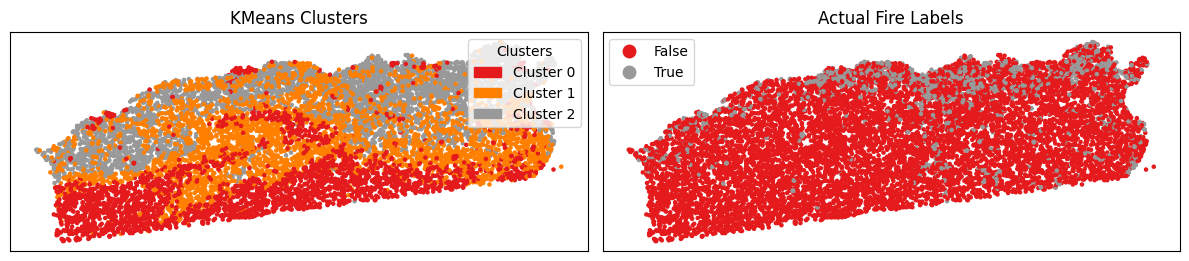

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import numpy as np

# Set figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ---- Plot KMeans clusters ----
cmap = cm.get_cmap('Set1')  # discrete colormap
gdf.plot(column='cluster', cmap=cmap, markersize=5, legend=False, ax=axes[0])
axes[0].set_title('KMeans Clusters')

# ---- Create colored legend that matches the map ----
cluster_ids = sorted(gdf['cluster'].unique())
# Normalize cluster IDs to [0,1] to pick the correct color from the cmap
colors = [cmap(i / (len(cluster_ids)-1)) for i in range(len(cluster_ids))]
patches = [mpatches.Patch(color=colors[i], label=f'Cluster {cluster_ids[i]}')
           for i in range(len(cluster_ids))]
axes[0].legend(handles=patches, title='Clusters', loc='upper right')

# ---- Plot actual fire labels ----
gdf.plot(column='fire', cmap='Set1', markersize=5, legend=True, ax=axes[1])
axes[1].set_title('Actual Fire Labels')

# Remove axis ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [ ]:
cluster_stats = gdf.groupby('cluster')[X.columns].mean()
print(cluster_stats)
gridcode_mode = (
    gdf.groupby('cluster')['GRIDCODE']
       .agg(lambda x: x.mode().iloc[0])
)

print(gridcode_mode)


         ALUM_SAT      CLAY  ELEC_COND    GRIDCODE  ORG_CARBON  PH_WATER  \
cluster                                                                    
0        0.045861  0.351394   0.577540  199.560447    0.331405  0.896549   
1        0.056567  0.423155   0.581423  144.176395    0.364194  0.929719   
2        0.079592  0.489689   0.578898   25.305433    0.406919  0.887375   

             SAND      SILT       TEB   TOTAL_N  ...  elevation1     ndvi1  \
cluster                                          ...                         
0        0.552801  0.568002  0.254273  0.471879  ...    0.294621  0.311338   
1        0.515091  0.633547  0.260499  0.514489  ...    0.336321  0.375456   
2        0.434216  0.696455  0.222539  0.549648  ...    0.270392  0.539624   

         precip_s1_log10  precip_s2_log10  precip_s3_log10  precip_s4_log10  \
cluster                                                                       
0               0.282556         0.287021         0.497023         0.2

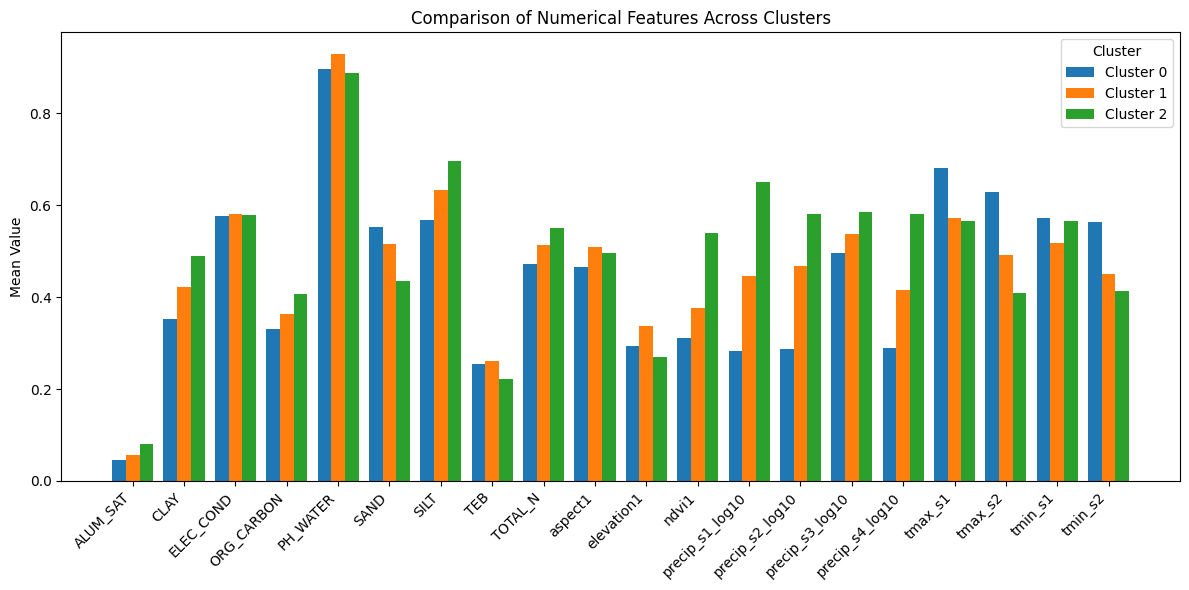

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Exclude GRIDCODE
numerical_features = X.columns.drop('GRIDCODE', errors='ignore')

# Compute mean per cluster
cluster_stats = gdf.groupby('cluster')[numerical_features].mean()

# Plot grouped bars
clusters = cluster_stats.index
n_clusters = len(clusters)
n_features = len(numerical_features)
bar_width = 0.8 / n_clusters  # space bars for each cluster

x = np.arange(n_features)  # feature positions

fig, ax = plt.subplots(figsize=(12,6))

for i, cluster_id in enumerate(clusters):
    ax.bar(x + i*bar_width, cluster_stats.loc[cluster_id],
           width=bar_width, label=f'Cluster {cluster_id}')

ax.set_xticks(x + bar_width*(n_clusters-1)/2)
ax.set_xticklabels(numerical_features, rotation=45, ha='right')
ax.set_ylabel("Mean Value")
ax.set_title("Comparison of Numerical Features Across Clusters")
ax.legend(title="Cluster")
plt.tight_layout()
plt.show()
